### Navigate to the location of folder ###

In [1]:
import os
# os.chdir('../../src/Enviroments/ExternalEnv/RPNet')
os.chdir('../../')

In [2]:
from os import listdir,getcwd,chdir,mkdir
from os.path import isfile,join,exists
from pathlib import Path
import sys
sys.path.append(join(getcwd(),str(Path('src'))))
getcwd()

'/home/welad1992/thesis'

### Importing required modules

In [3]:
### Importing basic libraries
import scipy.io
import numpy as np
import torch
from scipy import signal
# from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import random
import pandas as pd
import scipy
import pickle
import sklearn
from sklearn.preprocessing import MinMaxScaler
import warnings
import math
import csv

from scipy.signal import butter, lfilter, lfilter_zi
from pylab import plot, show, title, xlabel, ylabel, subplot

from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
import datetime

### Importing Custom Libraries
# from network import IncUNet
# os.chdir('../../src/Enviroments/ExternalEnv/RPNet')


1 Physical GPUs, 1 Logical GPUs


In [4]:
from Enviroments.ExternalEnv.RPNet.network_keras import IncUNet
from Enviroments.ExternalEnv.RPNet.utils import extract_RR

# Preprocessing #

### Navigate to the folder containing the model and data

In [5]:
data_path = "../../../../Data/mitdb/"
reference_path = "original_data/ref"
args = {}
args['datapath'] = data_path
args['dataset'] = 'mitdb'
args['evaluate_nstdb'] = False
args['db'] = 99

# Evaluate #

### Hyperparameters and Related parameters

In [6]:
BATCH_SIZE = 64
C,H,W = 1,1,5000
learn_rate = 0.05
num_epochs = 480

### Loading data via the pt files

In [7]:
patient_ecg_train = torch.load('/home/welad1992/thesis/src/Enviroments/ExternalEnv/RPNet/train.pt').numpy().reshape((-1,5000,1))
dist_transform_train = torch.load('/home/welad1992/thesis/src/Enviroments/ExternalEnv/RPNet/dist_transform_train.pt').numpy().reshape((-1,5000,1))
patient_ecg_test = torch.load('/home/welad1992/thesis/src/Enviroments/ExternalEnv/RPNet/test.pt').numpy().reshape((-1,5000,1))
dist_transform_test = torch.load('/home/welad1992/thesis/src/Enviroments/ExternalEnv/RPNet/dist_transform_test.pt').numpy().reshape((-1,5000,1))

In [8]:
model = IncUNet()
inputs_signal = Input(shape=(5000,1), name='input-RR')
print(model(inputs_signal).shape)
model.summary()
model.load_weights('Models/RR/RR_app.hdf5')

(None, 5000, 1)
Model: "inc_u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq1 (Sequential)            (None, 2499, 64)          36672     
_________________________________________________________________
seq2 (Sequential)            (None, 1250, 128)         176768    
_________________________________________________________________
sequential (Sequential)      (None, 1250, 128)         49792     
_________________________________________________________________
seq4 (Sequential)            (None, 624, 256)          753536    
_________________________________________________________________
sequential_1 (Sequential)    (None, 311, 512)          3071744   
_________________________________________________________________
seq6 (Sequential)            (None, 309, 512)          788992    
_________________________________________________________________
sequential_2 (Sequential)    (None, 155, 

In [9]:
y_pred_array = []
ecg = []

y_predict_test = model.predict(patient_ecg_test)
y_pred_array = y_predict_test.reshape((-1,5000))#[:,0,:]
y_pred_array.shape,y_predict_test.shape

((64, 5000), (64, 5000, 1))

### Post Processing ###

In [10]:
batch_no = 0

ecg = patient_ecg_test

peak_locs = []
for i in range(y_pred_array.shape[0]):
    peak_locs.append(scipy.signal.find_peaks(-y_pred_array[i,:],distance = 90,height = -0.2,prominence = 0.035)[0])

### Getting the amplitude values at valley location. 
y_roll_valleys = []
y = []
for j in range(len(peak_locs)):
    y = [ecg[j,i] for i in peak_locs[j]]
    y_roll_valleys.append(y)

### Plotting output ###

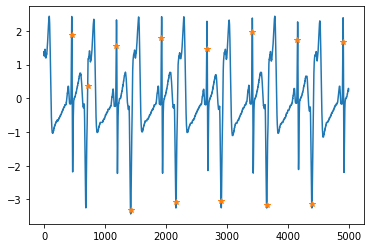

In [11]:
record_no = 45
plt.plot(ecg[record_no,:,0])

# plt.plot(y_pred_array[record_no])
# plt.plot(dist_transform_test[record_no])
plt.plot(peak_locs[record_no], y_roll_valleys[record_no],'*')

In [12]:
loss = np.mean(np.abs(y_pred_array-dist_transform_test.reshape(64,5000)),axis=1)
loss.mean(),loss.min(),loss.max()

(0.06685272, 0.017215652, 0.22545017)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fba4e501210>,
 'caps': [<matplotlib.lines.Line2D at 0x7fba4e501a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fba4e4f6e50>],
 'medians': [<matplotlib.lines.Line2D at 0x7fba4e50b390>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fba4e50b7d0>],
 'means': []}

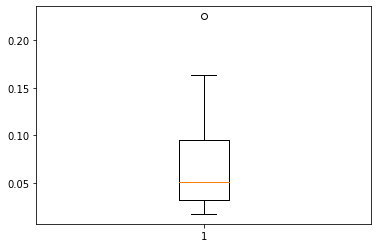

In [13]:
plt.boxplot(loss)

## Evaluate on CINC2017

In [14]:
# from Enviroments.ExternalEnv.EcgClassification.ecg import network,network_compression,network_compression_IoT
import Enviroments.ExternalEnv.EcgClassification.ecg.load as load
import Enviroments.ExternalEnv.EcgClassification.ecg.util as util

In [15]:
train = load.load_dataset("src/Enviroments/ExternalEnv/ecg-classification-AndrewNG/examples/cinc17/train.json")
preproc = load.Preproc(*train,app=True,CINC=True)

dev = load.load_dataset('src/Enviroments/ExternalEnv/ecg-classification-AndrewNG/examples/cinc17/dev.json')
train_gen = load.data_generator(32, preproc, *train)
dev_gen = load.data_generator(32,preproc, *dev)

100%|██████████| 852/852 [00:00<00:00, 5206.61it/s]


In [16]:
x_train,y_train = preproc.process(train[0],train[1])
x_train.shape,y_train[0].shape,y_train[1].shape

((5403, 8960, 1), (5403, 8960, 1), (5403, 35, 4))

In [17]:
x_dev,y_dev = preproc.process(dev[0],dev[1])
x_dev.shape,y_dev[0].shape,y_dev[1].shape

((602, 8960, 1), (602, 8960, 1), (602, 35, 4))

## Build CINC-RR dataset

In [18]:
RR_peaks_low_part = model.predict(x_train[:,:5000,])
RR_peaks_high_part= model.predict(x_train[:,8960-5000:,])

In [19]:
RR_predicted_cinc = np.concatenate([RR_peaks_low_part,RR_peaks_high_part[:,(10000-8960):]],axis=1)
RR_predicted_cinc.shape

(5403, 8960, 1)

In [20]:
RR_predicted_cinc17,peak_locs = extract_RR(x_train,RR_predicted_cinc.reshape((5403,8960)))

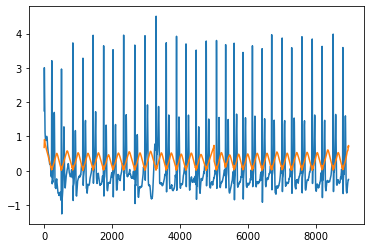

In [21]:
record_no = 30
high_index = 8960
plt.plot(x_train[record_no,:high_index])
plt.plot(RR_predicted_cinc[record_no,:high_index])
# plt.plot(peak_locs[record_no], RR_predicted_cinc17[record_no],'*')

In [22]:
np.save('Data/RR/train.npy',RR_predicted_cinc)
RR_predicted_cinc.shape

(5403, 8960, 1)

In [23]:
RR_peaks_low_part = model.predict(x_dev[:,:5000,])
RR_peaks_high_part= model.predict(x_dev[:,8960-5000:,])

In [24]:
RR_predicted_cinc = np.concatenate([RR_peaks_low_part,RR_peaks_high_part[:,(10000-8960):]],axis=1)
RR_predicted_cinc.shape

(602, 8960, 1)

In [25]:
RR_predicted_cinc17,peak_locs = extract_RR(x_dev,RR_predicted_cinc.reshape((602,8960)))

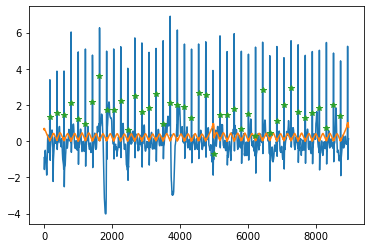

In [30]:
record_no = 95
high_index = 8960
plt.plot(x_dev[record_no,:high_index])
plt.plot(RR_predicted_cinc[record_no,:high_index])
plt.plot(peak_locs[record_no], RR_predicted_cinc17[record_no],'*')

In [27]:
np.save('Data/RR/test.npy',RR_predicted_cinc)
RR_predicted_cinc.shape

(602, 8960, 1)

In [31]:
new_data = np.load('Data/RR/test.npy')
new_data.shape

(602, 8960, 1)